(lecture15:cross-validation)=
# Cross validation for selecting the number of basis functions

In the previous section, we saw that the Fourier basis functions gave us a much better model for the motorcycle dataset.
But, how many basis functions should we choose?
To answer this question we are going to use a technique known as cross-validation.
The idea is simple.
Pick the number of basis functions that give you on average the smallest validation error.
By "validation" error, we mean the error on a subset of data not used in training.
By "average" we mean averaging over the possible ways in which you can split your dataset into training and validation.

Note that the validation dataset should be completely distinct from your test dataset.
So, it goes like this:

+ You split the original dataset into training and test subsets.
+ You repeatedly split the training subset into the subset you minimize the loss over and a validation subset.
+ For each candidate model, you evaluate the MSE on the validation subset and you average over all possible splits.
+ The model with the smallest MSE wins.

Let me demonstrate directly on the motorcycle data:

In [18]:
MAKE_BOOK_FIGURES=False

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)


def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

import numpy as np
import scipy.stats as st

In [19]:
# The url of the motorcycle data:
url = 'https://raw.githubusercontent.com/PurdueMechanicalEngineering/me-239-intro-to-data-science/master/data/motor.dat'
# Download the data
!curl -O $url
# Load the data
data = np.loadtxt('motor.dat')
# The inputs
x = data[:, 0]
# The outputs
y = data[:, 1]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2970  100  2970    0     0   8504      0 --:--:-- --:--:-- --:--:--  8510


Split into training and test:

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

The code for the Fourier design matrix:

In [21]:
def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    
        L           -       The "length" of the domain.
        num_terms   -       How many Fourier terms do you want. This is not the number
                            of basis functions you get. The number of basis functions
                            is 1 + num_terms / 2. The first one is a constant.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    # Loop over columns and add the polynomial
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)

Now we are going to loop over different number of Fourier basis functions, and for each one of them we are going to repeatedly split the training dataset in two, train on the first half and calculate the MSE on the second half.
Here we go:

In [22]:
from sklearn.model_selection import RepeatedKFold

# This will hold the average MSE for each possible number of basis functions
MSE = []
fourier_L = 60.0
rkf = RepeatedKFold(n_splits=10, n_repeats=10)
for fourier_terms in range(1, 20):
    mse_sum = 0.0
    for train_index, valid_index in rkf.split(x_train):
        x_train_train, x_train_valid = x_train[train_index], x_train[valid_index]
        y_train_train, y_train_valid = y_train[train_index], y_train[valid_index]
        Phi_fourier_train = get_fourier_design_matrix(x_train_train[:, None], fourier_L, fourier_terms)
        w_fourier, _, _, _ = np.linalg.lstsq(Phi_fourier_train, y_train_train, rcond=None)
        Phi_fourier_valid = get_fourier_design_matrix(x_train_valid[:, None], fourier_L, fourier_terms)
        y_valid_predict = np.dot(Phi_fourier_valid, w_fourier)
        MSE_fourier = np.mean((y_valid_predict - y_train_valid) ** 2)
        mse_sum += MSE_fourier
    MSE.append(mse_sum / rkf.get_n_splits())

And here are the results:

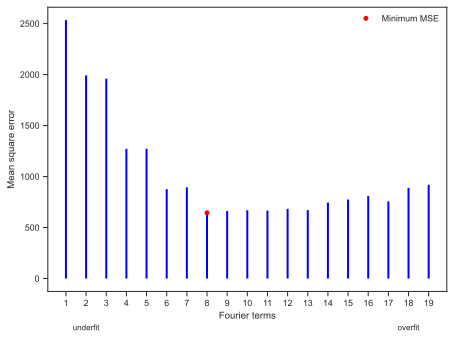

In [23]:
fig, ax = make_full_width_fig()
ax.vlines(range(1, len(MSE)+1), 0, MSE, color='blue', linewidth=2)
ax.set_xlabel('Fourier terms')
ax.set_ylabel('Mean square error')
ax.set_xticks(range(1, len(MSE)+1))
# Find the minimum MSE and its index
min_mse = min(MSE)
min_idx = MSE.index(min_mse)
# Plot a red dot at the minimum point
ax.plot(min_idx + 1, min_mse, 'ro', markersize=4, label='Minimum MSE')
ax.legend()
ax.text(2, -max(MSE)*0.2, 'underfit', fontsize=8, ha='center')
ax.text(18, -max(MSE)*0.2, 'overfit', fontsize=8, ha='center')
save_for_book(fig, 'ch15.fig20')

So, the best number of basis functions is about 10.